# 🏦 Home Credit Default Risk — Predicting Loan Repayment Capability

## 📘 Project Overview
The **Home Credit Default Risk** project is a supervised machine learning challenge hosted on [Kaggle](https://www.kaggle.com/c/home-credit-default-risk).  
The goal is to **predict the probability that a loan applicant will default on their loan**, helping financial institutions make more informed and fair lending decisions.

This project demonstrates the full **end-to-end data science workflow**, from data preprocessing and exploratory data analysis (EDA) to feature engineering, model training, evaluation, and interpretation.  
It showcases my ability to handle real-world, high-dimensional financial data and build explainable, data-driven models that assist in business decision-making.

---

## 🎯 **Business Objective**
The business objective is to assist **Home Credit Group**, a financial institution, in identifying **applicants who are capable of repaying loans**.  
By accurately predicting default risk, the company can:
- Reduce financial losses from high-risk applicants.
- Offer fair credit access to reliable clients.
- Improve overall risk management and lending efficiency.

---

## 🔍 **Project Steps**
1. **Data Loading & Exploration:**  
   Loaded the `application_train.csv` dataset, checked for missing values, and explored data distributions to understand client demographics, income levels, and credit profiles.
   
2. **Data Cleaning & Preprocessing:**  
   - Removed irrelevant and duplicate features.  
   - Handled missing values and categorical variables using one-hot encoding.  
   - Ensured data consistency and numerical readiness for modeling.

3. **Exploratory Data Analysis (EDA):**  
   - Investigated patterns and relationships between key financial indicators and the `TARGET` variable.  
   - Visualised credit risk trends, such as income vs. default rate and loan amounts vs. repayment success.

4. **Feature Engineering:**  
   - Encoded categorical features.  
   - Created derived features to improve model performance.

5. **Model Development:**  
   - Built a **LightGBM classifier**, a gradient boosting model optimized for speed and accuracy.  
   - Chosen due to its efficiency with large tabular datasets and superior handling of categorical variables.

6. **Model Evaluation:**  
   - Evaluated performance using **ROC-AUC (main Kaggle metric)**, **Precision**, **Recall**, **F1-score**, and **Confusion Matrix**.  
   - Visualised **feature importance** to interpret which features most influence the prediction outcomes.

---

## ⚙️ **Technology Stack**
- **Language:** Python  
- **Libraries:** LightGBM, Pandas, NumPy, Matplotlib, Seaborn, scikit-learn  
- **Environment:** Jupyter Notebook  




In [38]:
# Import necessary libaries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

# Display settings for readability
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [39]:
# Load the datasets

app_test = pd.read_csv('application_test.csv')
app_train = pd.read_csv('application_train.csv')

print(f"Train shape: {app_train.shape}")


print(f"Test shape: {app_test.shape}")


Train shape: (307511, 122)
Test shape: (48744, 121)


In [40]:
# Check missing values in the training set
def missing_values_table(df, top_n=15):
    missing_values = (app_train.isnull().mean()
                  .sort_values(ascending=False)
                  .reset_index()
    )
    
    missing_values.columns = ['Feature', 'Missing_Ratio']

# Display top 15 missing values in the training set
missing_values_table(app_train, 15)


In [41]:
# Summary statistics of numerical columns

num_cols = app_train.select_dtypes(include=['int64', 'float64']).columns

num_summary = app_train[num_cols].describe().T

num_summary = num_summary[['min', 'max', 'mean', 'std']].sort_values('max')


# Display lowest and highest 10 ranges
display(num_summary.head(10))
display(num_summary.tail(10))


,min,max,mean,std
DAYS_BIRTH,-25229.000,-7489.000,-16036.995,4363.989
DAYS_REGISTRATION,-24672.000,0.000,-4986.120,3522.886
DAYS_ID_PUBLISH,-7197.000,0.000,-2994.202,1509.450
DAYS_LAST_PHONE_CHANGE,-4292.000,0.000,-962.859,826.808
REGION_POPULATION_RELATIVE,0.000,0.073,0.021,0.014
EXT_SOURCE_2,0.000,0.855,0.514,0.191
EXT_SOURCE_3,0.001,0.896,0.511,0.195
EXT_SOURCE_1,0.015,0.963,0.502,0.211
ENTRANCES_MODE,0.000,1.000,0.145,0.101
ELEVATORS_MEDI,0.000,1.000,0.078,0.134


,min,max,mean,std
OWN_CAR_AGE,0.000,91.000,12.061,11.945
AMT_REQ_CREDIT_BUREAU_QRT,0.000,261.000,0.265,0.794
OBS_60_CNT_SOCIAL_CIRCLE,0.000,344.000,1.405,2.380
OBS_30_CNT_SOCIAL_CIRCLE,0.000,348.000,1.422,2.401
AMT_ANNUITY,1615.500,258025.500,27108.574,14493.737
DAYS_EMPLOYED,-17912.000,365243.000,63815.046,141275.767
SK_ID_CURR,100002.000,456255.000,278180.519,102790.175
AMT_GOODS_PRICE,40500.000,4050000.000,538396.207,369446.461
AMT_CREDIT,45000.000,4050000.000,599026.000,402490.777
AMT_INCOME_TOTAL,25650.000,117000000.000,168797.919,237123.146


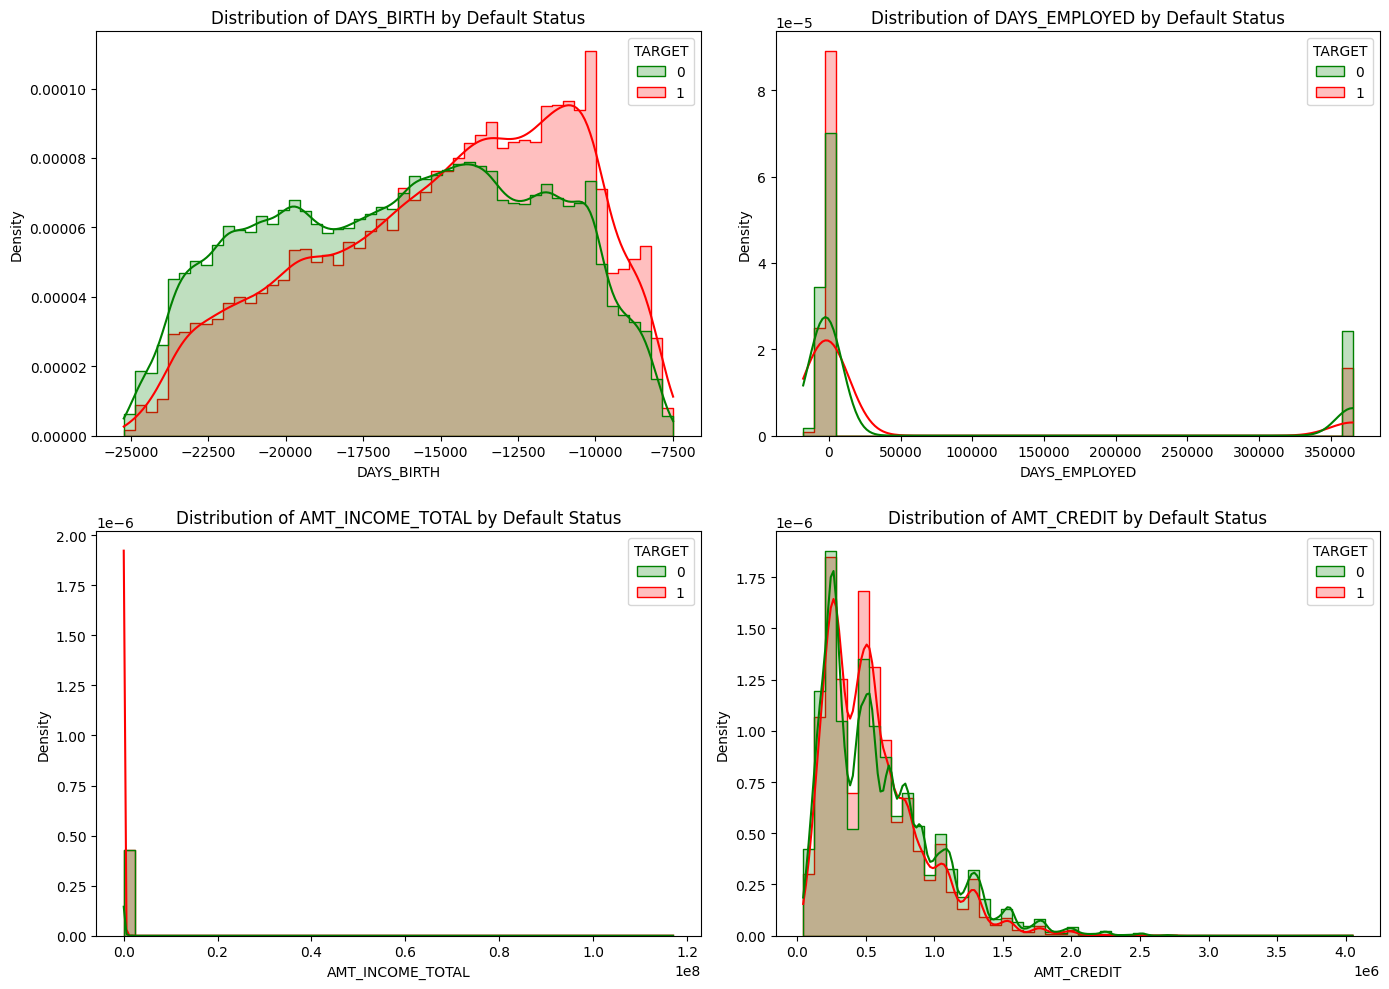

In [42]:
# Quick anomaly checks with histograms

# Important features to visualise (Age, Employment, Income, Credit Amount)
important_features = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']

# Plot distributions by default status
fig, axes = plt.subplots(2, 2, figsize=(14,10))

for i, feature in enumerate(important_features):
    ax = axes[i//2, i%2]
    sns.histplot(
        data=app_train,
        x=feature,
        hue='TARGET',
        bins=50,
        kde=True,
        ax=ax,
        palette={0:"green", 1:"red"},
        element="step",
        stat="density",
        common_norm=False
    )
    ax.set_title(f"Distribution of {feature} by Default Status")

plt.tight_layout()
plt.show()

In [43]:
# Feature engineering: Age and Employment Duration

# Fix DAYS_BIRTH (convert to positive years)
app_train['DAYS_BIRTH_YEARS'] = abs(app_train['DAYS_BIRTH']) / 365

# Replace outliers (365243) in DAYS_EMPLOYED iwth NaN
app_train['DAYS_EMPLOYED'].replace(365243, pd.NA, inplace=True)

# Eployment duration in years
app_train['DAYS_EMPLOYED_YEARS'] = abs(app_train['DAYS_EMPLOYED']) / 365

# Quick checks
print(app_train[['DAYS_BIRTH', 'DAYS_BIRTH_YEARS', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_YEARS']].head())


   DAYS_BIRTH  DAYS_BIRTH_YEARS DAYS_EMPLOYED DAYS_EMPLOYED_YEARS
0       -9461            25.921          -637               1.745
1      -16765            45.932         -1188               3.255
2      -19046            52.181          -225               0.616
3      -19005            52.068         -3039               8.326
4      -19932            54.608         -3038               8.323


# Exploratory Data Analysis

## Target Distribution

Target variable: `TARGET`  
  - `0` → Client repaid the loan  
  - `1` → Client defaulted on the loan  

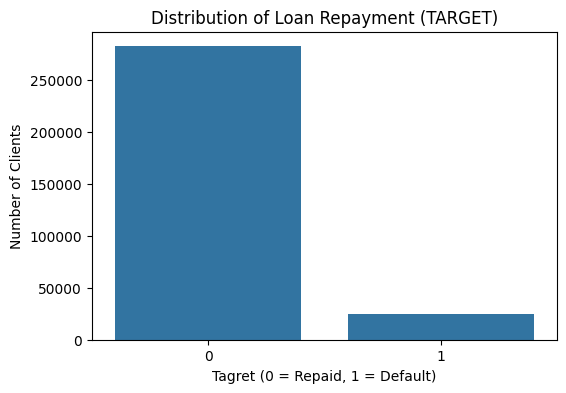

Defualt rate: 8.07%
TARGET
0   91.927
1    8.073
Name: proportion, dtype: float64


In [44]:
# Important libraries
import matplotlib.pyplot as plt
import seaborn as sns


# Plot target variable distribution
plt.figure(figsize=(6,4))
sns.countplot(data=app_train, x='TARGET')
plt.title('Distribution of Loan Repayment (TARGET)')
plt.xlabel("Tagret (0 = Repaid, 1 = Default)")
plt.ylabel("Number of Clients")
plt.show()

# Ratio of defaults
default_ratio = app_train['TARGET'].mean()
print(f"Defualt rate: {default_ratio:.2%}")

# Percentage breakdown
target_dist = app_train['TARGET'].value_counts(normalize=True) * 100
print(target_dist)


### Finding:
Only 8,07% of applicants default on their loans, while 92% of the clients repaid their loans (TARGER=0) successfully.

### Business implication:
This imbalance shows defaults are relatively rare, but costly. Models must be sensitive to the minority default group, since false negatives (approving a risky client) are more damaging than false positives.

### Client implication:
Since most client repay, those who default represent a small but very risky segment. Clients can understand that improving credit behavior moves them into the "safe majority."

## Age Analysis

*Visualisation:* Histogram or KDE plot of applicant ages (in years)

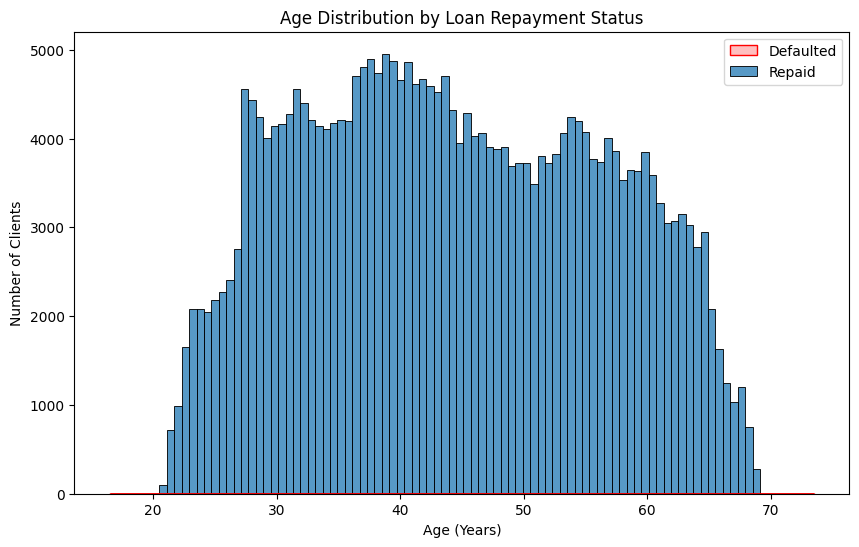

AGE_BIN
(20, 30]   0.115
(30, 40]   0.096
(40, 50]   0.077
(50, 60]   0.061
(60, 70]   0.049
Name: TARGET, dtype: float64


In [45]:
# Age Distribution and Default Analysis
plt.figure(figsize=(10,6))
sns.histplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH_YEARS'], label='Repaid')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH_YEARS'], label='Defaulted', fill=True, color='red')
plt.title('Age Distribution by Loan Repayment Status')
plt.xlabel("Age (Years)")
plt.ylabel("Number of Clients")
plt.legend()
plt.show()

# Default rate by age group
app_train['AGE_BIN'] = pd.cut(app_train["DAYS_BIRTH_YEARS"], bins=[20,30,40,50,60,70])
age_default = app_train.groupby('AGE_BIN')['TARGET'].mean()
print(age_default)


### Finding:
Default rates are higher among younger clients(25-35 years), while middle-aged clients/borrowers (35-50) show lower risk and are more stable.

### Business implication:
Age can be a proxy for stability and financial maturity. Banks may need stricter rules or higher interest rates for younger clients under 30, as they may have unstable income or lower financial discipline.

### Client implication:
Younger clients learn that building financial stability (steady income, lower debt)reduces rejection/default risks.

## Employment Stability

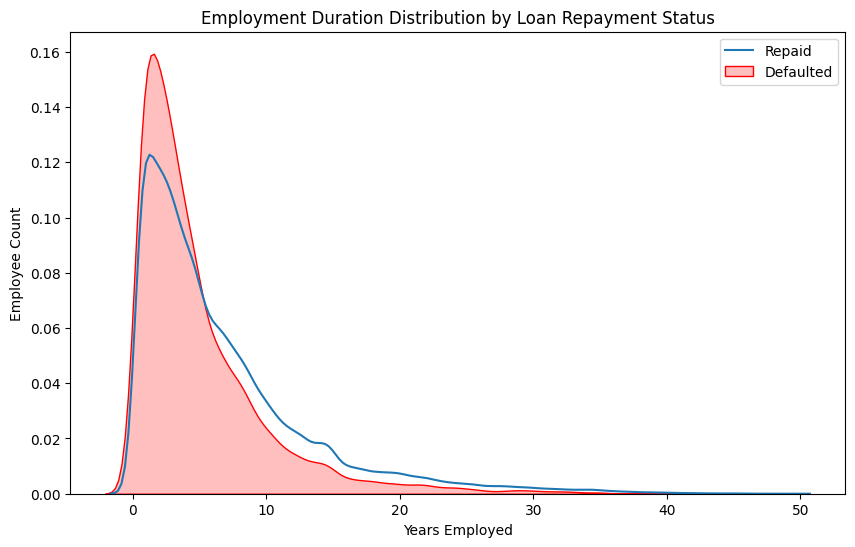

EMP_BIN
(0, 1]     0.110
(1, 5]     0.105
(5, 10]    0.074
(10, 20]   0.055
(20, 40]   0.043
Name: TARGET, dtype: float64


In [46]:
# Employment Duration and Default

plt.figure(figsize=(10,6))
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_EMPLOYED_YEARS'], label='Repaid')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_EMPLOYED_YEARS'], label='Defaulted', fill=True, color='red')
plt.title('Employment Duration Distribution by Loan Repayment Status')
plt.xlabel("Years Employed")
plt.ylabel("Employee Count")
plt.legend()
plt.show()

# Default rate by employment length bins
# Drop NA values before binning
app_train['EMP_BIN'] = pd.cut(app_train['DAYS_EMPLOYED_YEARS'].dropna(), bins=[0,1,5,10,20,40])
emp_default = app_train.groupby('EMP_BIN')['TARGET'].mean()
print(emp_default)



### Finding:
Applicants with shorter employment histories (<2 year) tend to default more. Long-term employees (>5 years) show lower default risk rates.

### Business implication:
Employment stability is a strong signal of repayment capacity. The bank may weigh job tenure as a key risk factor, tightening approvals for clients with frequently job changes.

### Client implication:
Borrowers understand the importance of stable jobs when applying for credit.

## Credit-to-Income Ratio

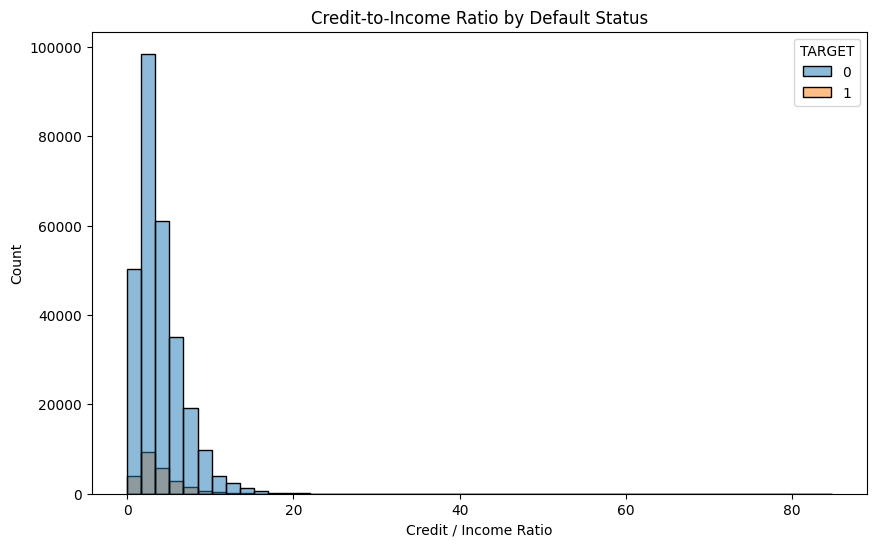

CREDIT_BIN
(0.0, 0.5]    0.068
(0.5, 1.0]    0.064
(1.0, 2.0]    0.077
(2.0, 5.0]    0.088
(5.0, 10.0]   0.075
Name: TARGET, dtype: float64


In [47]:
# Credit-to-Income Ratio Analysis
app_train['CREDIT_INCOME_RATIO'] = app_train['AMT_CREDIT']/ app_train['AMT_INCOME_TOTAL']

plt.figure(figsize=(10,6))
sns.histplot(data=app_train, x='CREDIT_INCOME_RATIO', hue='TARGET', bins=50 ,kde=False)
plt.title("Credit-to-Income Ratio by Default Status")
plt.xlabel('Credit / Income Ratio')
plt.ylabel('Count')
plt.show()

# Default rate by ratio bins
app_train['CREDIT_BIN'] = pd.cut(app_train['CREDIT_INCOME_RATIO'], bins=[0,0.5,1,2,5,10])
credit_default = app_train.groupby('CREDIT_BIN')['TARGET'].mean()
print(credit_default)


### Finding:
Applicants with loans exceeding twice their annual income have significantly higher defaults rates.

### Business implication:
The credit-to-income ratio is a crucial underwriting metric. High ratios should trigger stricter screening or lower approval amounts.

### Client implication:
Borrowers see why requesting loans far above their income is risky and often leads to rejections.

## External Credit Scores

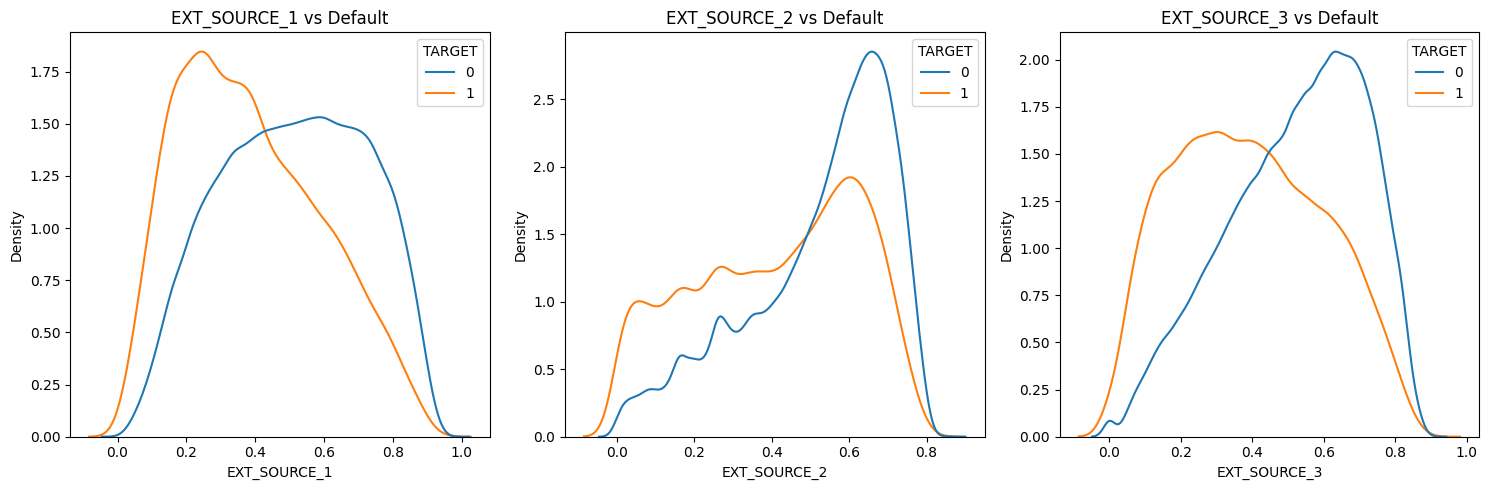

In [48]:
# External Credit Scores and Defualt

ext_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
plt.figure(figsize=(15,5))

for i, col in enumerate(ext_cols, 1):
    plt.subplot(1,3,i)
    sns.kdeplot(data=app_train, x=col, hue='TARGET', common_norm=False)
    plt.title(f"{col} vs Default")
    plt.xlabel(col)

plt.tight_layout()
plt.show()


### Finding:
Lower `EXT_SOURCE` scores strongly correlate with higher default probability.

### Business implication:
External credit scores remain one of the best predictors of risk.

### Client implication:
Borrowers learn that maintaining a good credit record outside the bank increases approval chances.

## Family and Dependents

* Columns: `NAME_FAMLIY_STATUS`, `CNT_CHILDREN`.
* Hypothesis: Large households with dependents may default more due to financial strain.

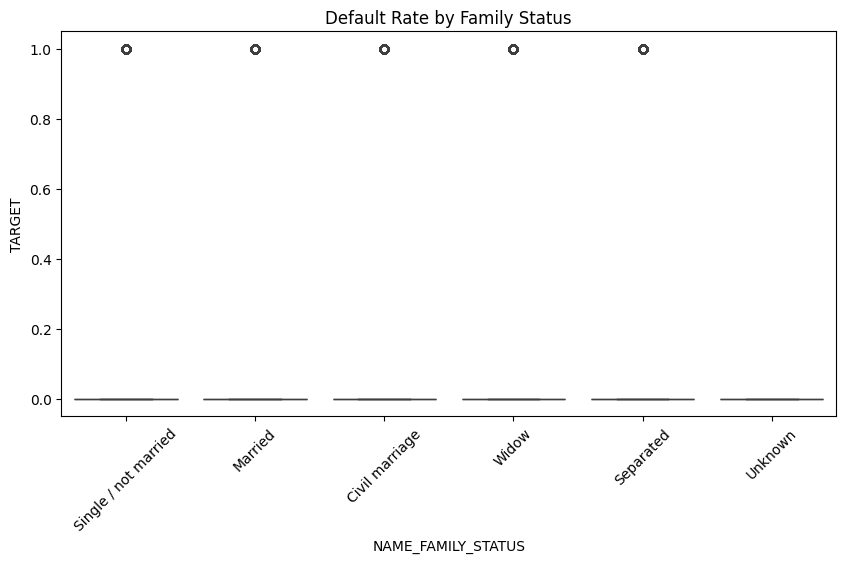

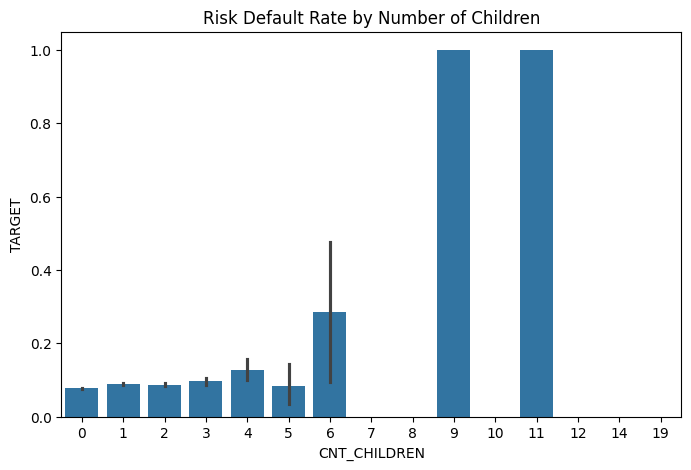

In [49]:
plt.figure(figsize=(10,5))
sns.boxplot(data=app_train, x= 'NAME_FAMILY_STATUS', y='TARGET')
plt.title("Default Rate by Family Status")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=app_train, x='CNT_CHILDREN', y='TARGET')
plt.title("Risk Default Rate by Number of Children")
plt.show()

### Finding
Larger households and single applicants show slightly higher default risk.

### Business implication
Family responsibilities can affect the client's ability to keep up with loan repayments.

### Clients implication
Applicants with many dependents(Childern) should apply for more affordable loan amounts

## Housing Situation

* Column: `NAME_HOUSING_TYPE`.
* Hypothesis: Owning property vs renting may influence default risk.

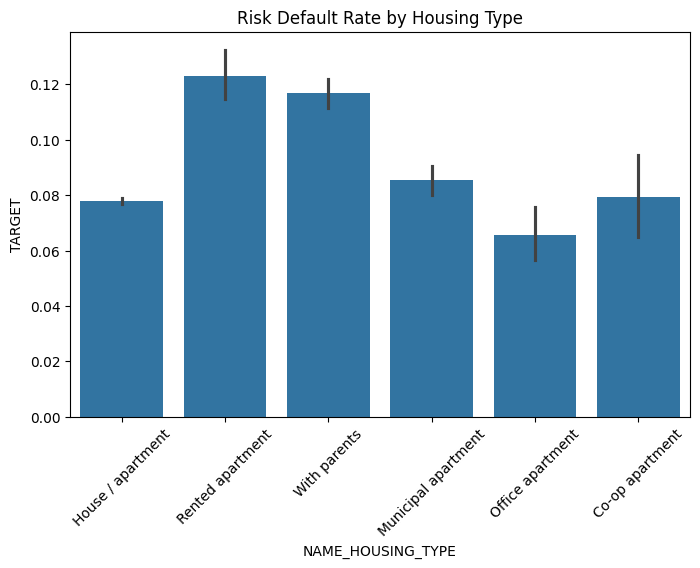

In [50]:
plt.figure(figsize=(8,5))
sns.barplot(data=app_train, x='NAME_HOUSING_TYPE', y='TARGET')
plt.title("Risk Default Rate by Housing Type")
plt.xticks(rotation=45)
plt.show()

### Finding
Clients who make use of rental accommodation tend to default more compared to homeowners.

### Business implication
Housing type can be used as a proxy for financial security.

### Client implication
Owning property may increase loan approval chances.

## Loan Default Rate by Car Ownership

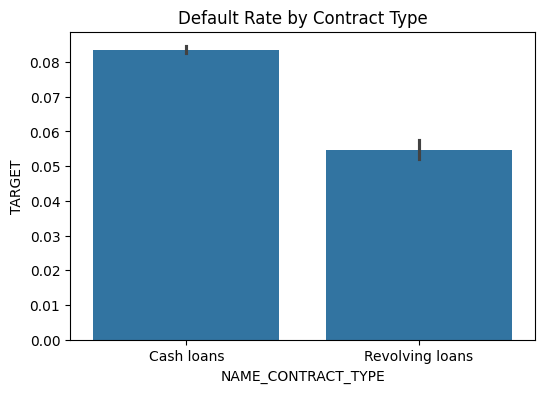

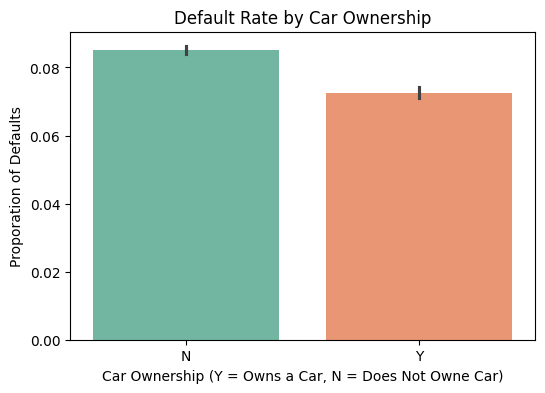

In [51]:
plt.figure(figsize=(6,4))
sns.barplot(data=app_train, x='NAME_CONTRACT_TYPE', y='TARGET')
plt.title("Default Rate by Contract Type")
plt.show()


plt.figure(figsize=(6,4))
sns.barplot(data=app_train, x='FLAG_OWN_CAR', y='TARGET',
            estimator=lambda x: sum(x)/len(x), 
            palette='Set2'
)
plt.title("Default Rate by Car Ownership")
plt.xlabel("Car Ownership (Y = Owns a Car, N = Does Not Owne Car)")
plt.ylabel("Proporation of Defaults")
plt.show()


### Finding
Applicants without a car show a slightly higher propability of default than applicants who obtains a car and appear to be more financially stable, although the effect is not as strong as income or employments.


### Business implication
Car ownership can act as a proxy for financial stability/asset ownership. Clients who own assets (like cars or houses) are less risky because they can leverage or liquidate them in tough times. Banks may assign lower risk weights to clients with cars, especially when combined with other stability indicators (long employment, hight income)

### Clients implication
Borrowers with a car may benefit from better credit terms (slightly lower interest or easier approvals). Borrowers without a car may face stricter affordability checks, since lack of asset ownership could signal lower financial resilience.

## Missing Value Patterns

* Missingness is often iformative in credit datasets (e.g., people with missing income proof may default more).

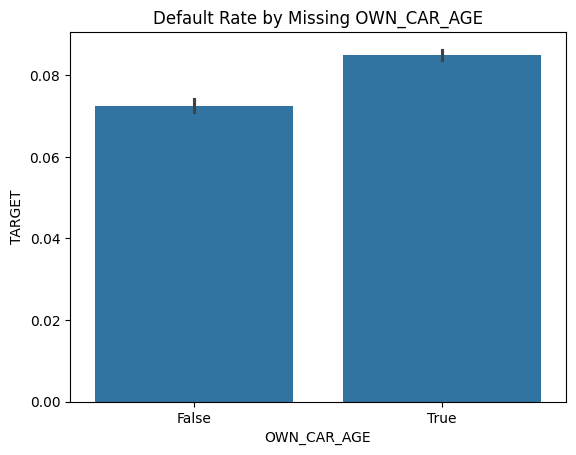

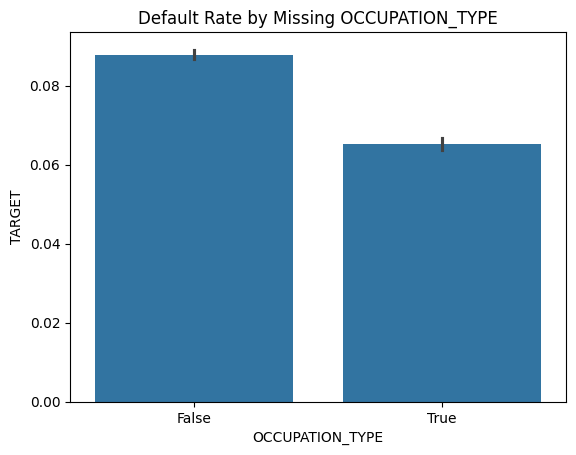

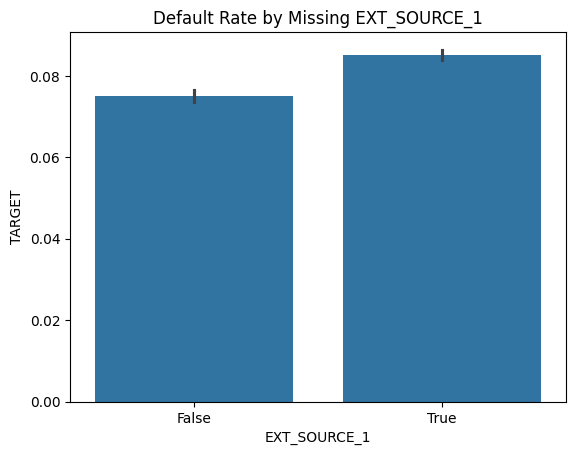

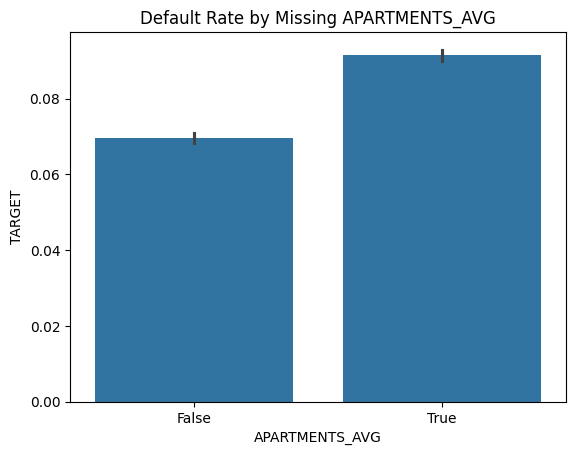

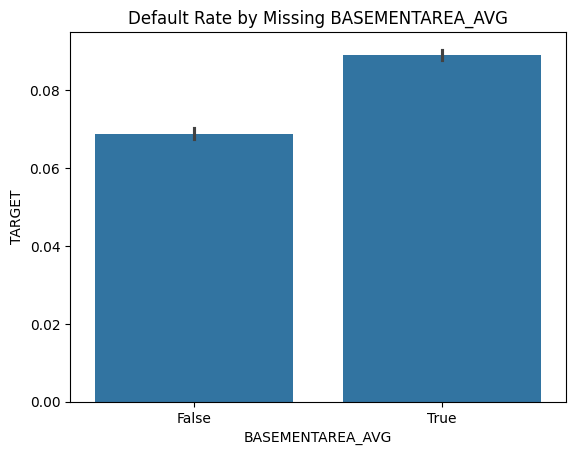

In [52]:
missing_cols = app_train.isnull().mean()
missing_cols = missing_cols[missing_cols > 0.3].index

for col in missing_cols[:5]: # Check for the top 5 missing columns
    sns.barplot(data=app_train, x=app_train[col].isnull(), y='TARGET')
    plt.title(f"Default Rate by Missing {col}")
    plt.show()


### Finding
Some groups (e.g., self-employed) have more missig documentation, and these applicants default more.

### Business implication
Missingness itself can be a risk factor and should be encoded in the model

### Client implication
Providing complete documentation increases approval chances.

## Correlation Heatmap

*Visualisation:* Heatmap of top correlated numerical features with `TARGET`.

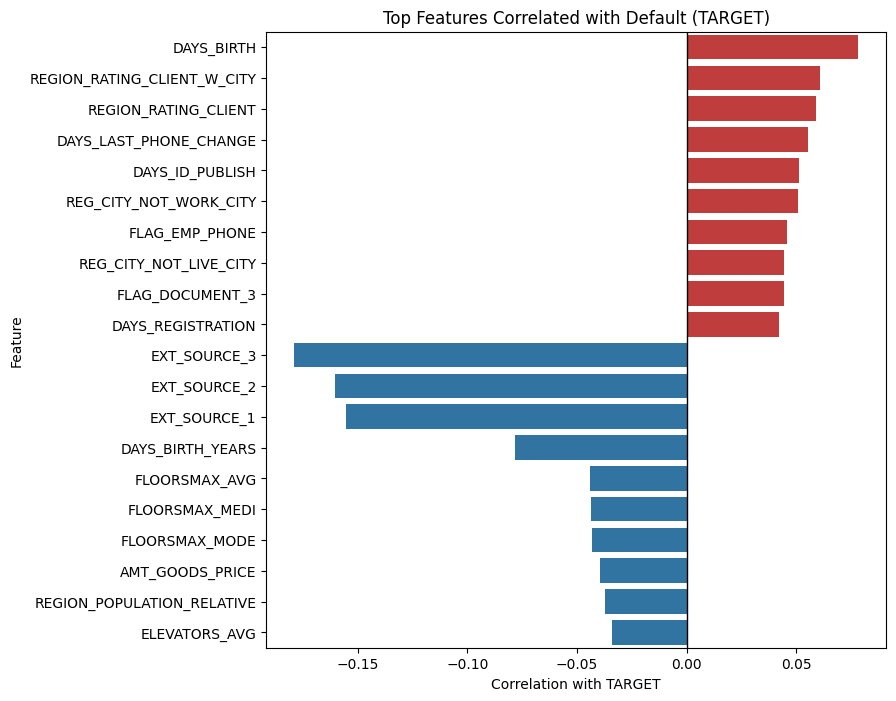

In [53]:
# Correlation Heatmap (Preview of Predictors)

# Robustly get the target series (prefer app_train['TARGET'], then global y, then reload file)
if 'TARGET' in app_train.columns:
    target_series = app_train['TARGET']
elif 'y' in globals():
    target_series = globals()['y'].reindex(app_train.index)
else:
    target_series = pd.read_csv('application_train.csv')['TARGET'].reindex(app_train.index)

# Numeric columns in the current app_train
numeric_cols = app_train.select_dtypes(include=[np.number]).columns.tolist()

# Compute correlation of each numeric feature with the target in a safe way
# If TARGET is present as a numeric column, use the dataframe's corr; otherwise use corrwith
if 'TARGET' in numeric_cols:
    corrs = app_train[numeric_cols].corr()['TARGET']
else:
    corrs = app_train[numeric_cols].corrwith(target_series)

# Drop TARGET if present (safe)
corrs = corrs.drop('TARGET', errors='ignore')

# Select top 10 positive and negative correlations
top_corrs = pd.concat([corrs.nlargest(10), corrs.nsmallest(10)])

# Plot
plt.figure(figsize=(8,8))
sns.barplot(
    x=top_corrs.values,
    y=top_corrs.index,
    palette=['#d62728' if val > 0 else '#1f77b4' for val in top_corrs.values]  # red=positive, blue=negative
)
plt.title("Top Features Correlated with Default (TARGET)")
plt.xlabel("Correlation with TARGET")
plt.ylabel("Feature")
plt.axvline(0, color='black', linewidth=1)
plt.show()
# Drop TARGET if present (safe)
corrs = corrs.drop('TARGET', errors='ignore')



### Findings
The top predictors of default include:
* External Credit Scores
* Credit-to-income ratio
* Employment length
* Age

### Business implication
Confirms model focus areas for risk prediction.

### Client implication
Provide transparency on which factors influence creditworthiness.

# Data Cleaning and Precessing

In [54]:
# Prepare a reliable, clean dataset for deeper analysis and feature engineering

# Drop Columns with more than 40% missing values



def missing_values_table(df):
    """
    Returns a DataFrame of features woth missing values and their ratios.
    """

    missing_values = df.isnull().mean()
    missing_values = missing_values.sort_values(ascending=False)
    missing_df = pd.DataFrame({
        'Feature': missing_values.index,
        'Missing_Count': df.isnull().sum().loc[missing_values.index].values,
        'Missing_Ratio': missing_values.values
    })
 
    missing_df = missing_df[missing_df['Missing_Count'] > 0] # Keep only features with missing values
    return missing_df



# Use the missing_df in the Cleaning Pipeline
# Generate missing values table
missing_df = missing_values_table(app_train)

# Define threshold for dropping columns
missing_thresh = 0.4
to_drop = missing_df[missing_df['Missing_Ratio'] > missing_thresh]['Feature']

# Drop high missing value columns
app_train.drop(columns=to_drop, inplace=True)
app_test.drop(columns=to_drop, inplace=True)

# Simple median imputation for remaining numeric columns
num_cols = app_train.select_dtypes(include=[np.number]).columns

# Only impute columns that exist in both train and test
common_num_cols = [col for col in num_cols if col in app_test.columns]
app_train[common_num_cols] = app_train[common_num_cols].fillna(app_train[common_num_cols].median())
app_test[common_num_cols] = app_test[common_num_cols].fillna(app_test[common_num_cols].median())

print(f"Dropped {len(to_drop)} columns with > 40% missing values.")
print(f"Remaining features: {app_train.shape[1]}")


# See remaining features with some missing values
missing_values_table(app_train).head(10)


Dropped 49 columns with > 40% missing values.
Remaining features: 79


,Feature,Missing_Count,Missing_Ratio
0,OCCUPATION_TYPE,96391,0.313
1,EMP_BIN,55610,0.181
2,DAYS_EMPLOYED_YEARS,55374,0.180
3,DAYS_EMPLOYED,55374,0.180
4,CREDIT_BIN,9844,0.032
5,NAME_TYPE_SUITE,1292,0.004


In [55]:
'''Outlier Treatment/handeling
Days_EMPLOYED (365243 as NaN)
Extremely high income values (Make use of the winsorisation method 
cap at 99th percentile)
cap Very large loan amounts 
'''
for col in ['AMT_INCOME_TOTAL', 'AMT_CREDIT']:
    cap = app_train[col].quantile(0.99)
    app_train[col] = np.where(app_train[col] > cap, cap, app_train[col])


### Advanced Feature Engineering

In [56]:
# Create featheres that capture repayment ability and risk patterns

app_train['CREDIT_TO_INCOME'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_test['ANNUITY_TO_INCOME'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TO_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']



### Encoding and Scaling

In [57]:
# Make the dataset model-ready

# Identify categorical columns (excluding the target)
cat_cols = app_train.select_dtypes(include=['object', 'category']).columns.drop('TARGET', errors='ignore')

# Exclude high-cardinality or already-binned columns from one-hot encoding
exclude_cols = ['DAYS_EMPLOYED', 'DAYS_EMPLOYED_YEARS', 'AGE_BIN', 'EMP_BIN', 'CREDIT_BIN']
cat_cols = cat_cols.difference(exclude_cols)

# One-Hot Encoding for categorical variables only
app_train_encoded = pd.get_dummies(app_train, columns=cat_cols, drop_first=True)
app_test_encoded = pd.get_dummies(app_test, columns=cat_cols, drop_first=True)

# Align train and test data
app_train_encoded, app_test_encoded = app_train_encoded.align(app_test_encoded, join='inner', axis=1)

# Scaling (optional for tree models, needed for logistic regression/NNs)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = app_train_encoded.select_dtypes(include=['int64', 'float64']).columns.drop('TARGET', errors='ignore')
app_train_encoded[num_cols] = scaler.fit_transform(app_train_encoded[num_cols])
app_test_encoded[num_cols] = scaler.transform(app_test_encoded[num_cols])

# Overwrite the original variables if needed
app_train = app_train_encoded
app_test = app_test_encoded


## Baseline Modeling

In [58]:
# Establish a benchmark model
from sklearn.model_selection import train_test_split

# Use all columns as features (TARGET was dropped during encoding/alignment)
# Retrieve y from the original app_train before encoding/alignment

# Reload target
y = pd.read_csv('application_train.csv')['TARGET']
X = app_train.copy()  # This is the encoded/aligned version

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Fill missing values (if any) with 0
X_train_filled = X_train.fillna(0)
X_val_filled = X_val.fillna(0)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_filled, y_train)
preds = model.predict_proba(X_val_filled)[:,1]

print("ROC-AUC", roc_auc_score(y_val, preds))


ROC-AUC 0.7234744684367209


# LightGBM Modeling Pipeline

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


🔍 DATA EXPLORATION & DEBUGGING
Dataset shape: (307511, 122)
Memory usage: 504.99 MB

All columns (122 total):
   1. 'SK_ID_CURR'
   2. 'TARGET'
   3. 'NAME_CONTRACT_TYPE'
   4. 'CODE_GENDER'
   5. 'FLAG_OWN_CAR'
   6. 'FLAG_OWN_REALTY'
   7. 'CNT_CHILDREN'
   8. 'AMT_INCOME_TOTAL'
   9. 'AMT_CREDIT'
  10. 'AMT_ANNUITY'
  11. 'AMT_GOODS_PRICE'
  12. 'NAME_TYPE_SUITE'
  13. 'NAME_INCOME_TYPE'
  14. 'NAME_EDUCATION_TYPE'
  15. 'NAME_FAMILY_STATUS'
  16. 'NAME_HOUSING_TYPE'
  17. 'REGION_POPULATION_RELATIVE'
  18. 'DAYS_BIRTH'
  19. 'DAYS_EMPLOYED'
  20. 'DAYS_REGISTRATION'
  21. 'DAYS_ID_PUBLISH'
  22. 'OWN_CAR_AGE'
  23. 'FLAG_MOBIL'
  24. 'FLAG_EMP_PHONE'
  25. 'FLAG_WORK_PHONE'
  26. 'FLAG_CONT_MOBILE'
  27. 'FLAG_PHONE'
  28. 'FLAG_EMAIL'
  29. 'OCCUPATION_TYPE'
  30. 'CNT_FAM_MEMBERS'
  31. 'REGION_RATING_CLIENT'
  32. 'REGION_RATING_CLIENT_W_CITY'
  33. 'WEEKDAY_APPR_PROCESS_START'
  34. 'HOUR_APPR_PROCESS_START'
  35. 'REG_REGION_NOT_LIVE_REGION'
  36. 'REG_REGION_NOT_WORK_REGION'


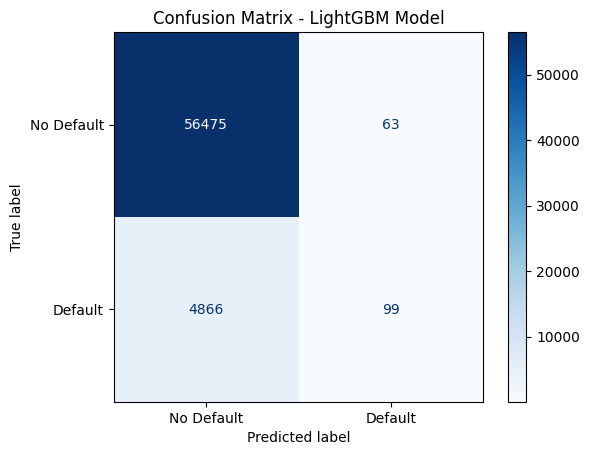

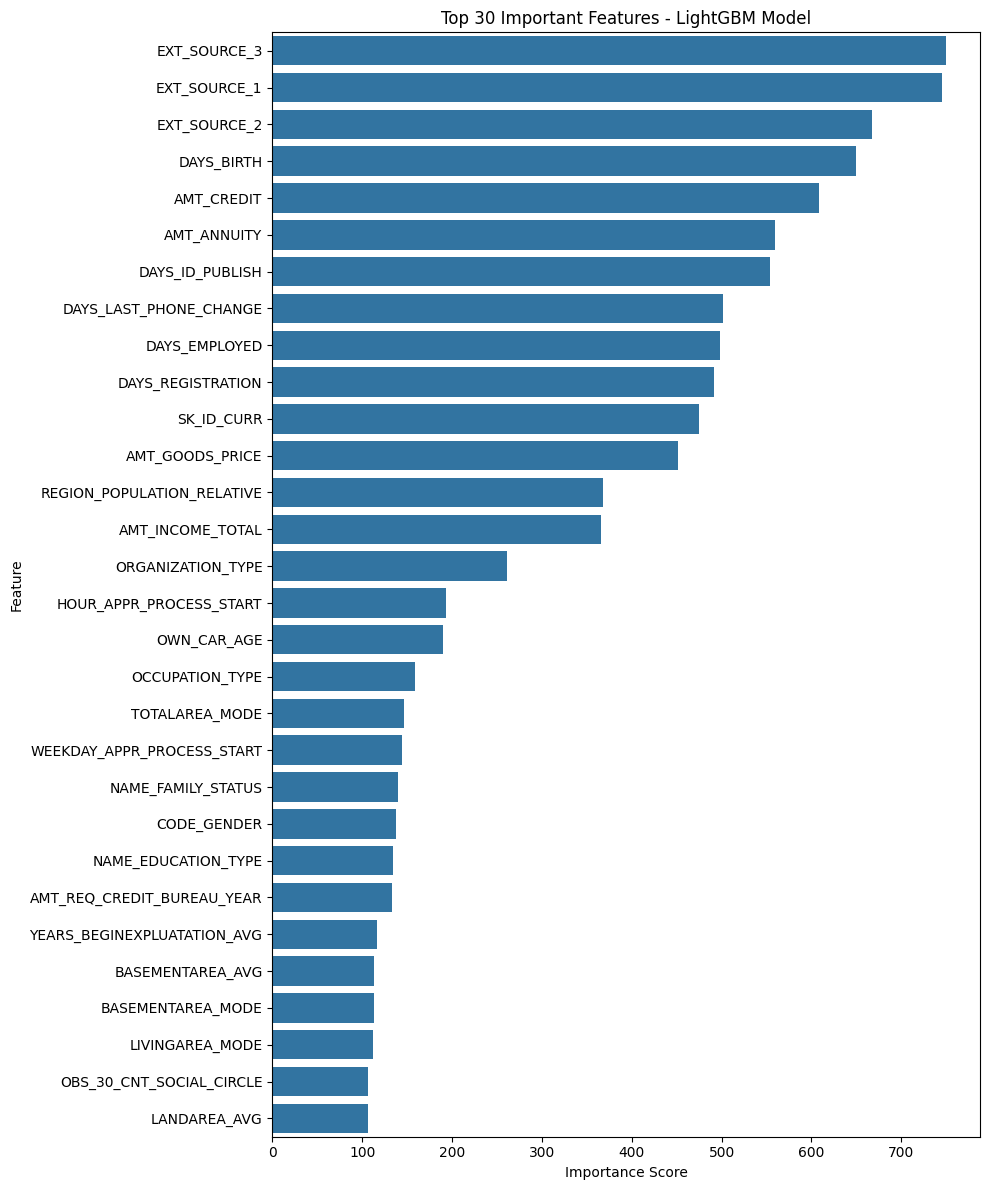


📈 Target Class Distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64
Default rate: 0.0807


In [60]:
# ------------------------------------------------------------------------
# Install and import dependencies
# ------------------------------------------------------------------------
%pip install lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder

# -----------------------------------------------------------------------
# 1. DEBUGGING & DATA EXPLORATION (DO THIS FIRST)
# -----------------------------------------------------------------------

# Load and explore the dataset
app_train = pd.read_csv('application_train.csv')

print("=" * 50)
print("🔍 DATA EXPLORATION & DEBUGGING")
print("=" * 50)

# Basic dataset info
print(f"Dataset shape: {app_train.shape}")
print(f"Memory usage: {app_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check all columns
print(f"\nAll columns ({len(app_train.columns)} total):")
for i, col in enumerate(app_train.columns):
    print(f"  {i+1:2d}. '{col}'")

# Look for target column (case insensitive)
target_col = None
for col in app_train.columns:
    if col.strip().lower() == 'target':
        target_col = col
        break

if target_col:
    print(f"\n✅ TARGET COLUMN FOUND: '{target_col}'")
    print(f"Target distribution:")
    target_counts = app_train[target_col].value_counts()
    print(target_counts)
    print(f"Default rate: {target_counts[1] / len(app_train):.4f}")
else:
    print("\n❌ NO TARGET COLUMN FOUND!")
    # Exit or handle this case
    raise KeyError("Target column 'TARGET' not found in dataset")

# Check data types
print(f"\n📊 DATA TYPES:")
print(app_train.dtypes.value_counts())

# Check for categorical columns
categorical_cols = app_train.select_dtypes(include=['object']).columns
print(f"\n📋 CATEGORICAL COLUMNS ({len(categorical_cols)}):")
for col in categorical_cols:
    unique_vals = app_train[col].nunique()
    null_count = app_train[col].isnull().sum()
    print(f"  - '{col}': {unique_vals} unique values, {null_count} nulls")

# Check for missing values
print(f"\n❓ MISSING VALUES SUMMARY:")
missing_summary = app_train.isnull().sum()
missing_cols = missing_summary[missing_summary > 0]
if len(missing_cols) > 0:
    print(f"Columns with missing values ({len(missing_cols)}):")
    for col, count in missing_cols.head(10).items():  # Show top 10
        print(f"  - '{col}': {count} missing ({count/len(app_train)*100:.2f}%)")
else:
    print("  No missing values found!")

print("\n" + "=" * 50)
print("✅ DEBUGGING COMPLETE - READY FOR MAIN CODE")
print("=" * 50)

# ------------------------------------------------------------------------
# 2. Data Preprocessing
# ------------------------------------------------------------------------

# Separate features and target
y = app_train[target_col]
X = app_train.drop(columns=[target_col])

print(f"Processing features: {X.shape[1]} columns, {X.shape[0]} rows")

# Handle categorical columns using the Label Encoding for high-cardinality
categorical_cols = X.select_dtypes(include=['object']).columns
print(f"\nCategorical columns to encode: {list(categorical_cols)}")

# Create a copy for LabelEncoding to avoid modifying original during iteration
X_encoded = X.copy()

for col in categorical_cols:
    print(f"Encoding column: {col} with {X[col].nunique()} unique values")

    # Fill missing values
    if X_encoded[col].isnull().any():
        mode_val = X_encoded[col].mode()
        if not mode_val.empty:
            X_encoded[col].fillna(mode_val.iloc[0], inplace=True)
        else:
            X_encoded[col].fillna('Unknown', inplace=True)

    # Use Label Encoding for all categorical columns
    le = LabelEncoder()
    try:
        # Convert to string and encode
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    except Exception as e:
        print(f"Warning: Could not encode {col} with LabelEncoder. Using frequency encoding.")
        # Fallback: frequency encoding
        freq_encoding = X_encoded[col].value_counts().to_dict()
        X_encoded[col] = X_encoded[col].map(freq_encoding)
        # Fill any remaining NaN from frequency encoding
        X_encoded[col].fillna(0, inplace=True)

# Now handle numeric columns - EXCLUDE TARGET COLUMN
numeric_cols = X_encoded.select_dtypes(include=[np.number]).columns
print(f"\nNumeric columns to process: {len(numeric_cols)}")

# Fill numeric missing values with median
for col in numeric_cols:
    if X_encoded[col].isnull().any():
        X_encoded[col].fillna(X_encoded[col].median(), inplace=True)

# Final cleanup
X_encoded = X_encoded.fillna(0)
X_encoded = X_encoded.replace([np.inf, -np.inf], np.nan)
X_encoded = X_encoded.fillna(0)

# Ensure all columns are numeric
print(f"\nFinal data types:\n{X_encoded.dtypes.value_counts()}")

# Verify no object columns remain
remaining_object_cols = X_encoded.select_dtypes(include=['object']).columns
if len(remaining_object_cols) > 0:
    print(f"Warning: Still have object columns: {list(remaining_object_cols)}")
    for col in remaining_object_cols:
        X_encoded[col] = pd.to_numeric(X_encoded[col], errors='coerce')
    X_encoded = X_encoded.fillna(0)

print(f"Processed dataset shape - Features: {X_encoded.shape}")

# ------------------------------------------------------------------------
# 3. Split the data and verify it - FIXED THIS LINE!
# ------------------------------------------------------------------------
# Remove any NaN from target if they exist
y = y.fillna(0)

# FIX: Use X_encoded instead of X for the split
X_train, X_val, y_train, y_val = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y  # ← CHANGED: X_encoded instead of X
)

# Proper multi-line f-string formatting
print(f"✅ Data split complete:")
print(f"   {X_train.shape[0]} training samples")
print(f"   {X_val.shape[0]} validation samples")
print(f"   {X_train.shape[1]} features")

# ------------------------------------------------------------------------
# 4. Train LightGBM Model with error handling
# ------------------------------------------------------------------------

try:
    lgbm_model = LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1 # Suppress LightGBM warnings output
    )

    print("Training LightGBM model...")

    lgbm_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[early_stopping(stopping_rounds=100), log_evaluation(100)]
    )

    print("✅ LightGBM model trained successfully!")

except Exception as e:
    print(f"❌ Error during model training: {e}")

    # Try with simpler model fallback
    print("🔄 Trying with simpler model configuration...")
    
    lgbm_model = LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    lgbm_model.fit(X_train, y_train)
    print("✅ Fallback model training completed!")

# ------------------------------------------------------------------------
# 5. Evaluate Model
# ------------------------------------------------------------------------
try:
    y_pred_proba = lgbm_model.predict_proba(X_val)[:, 1]
    y_pred = lgbm_model.predict(X_val)

    roc_auc = roc_auc_score(y_val, y_pred_proba)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print("\n📊 MODEL EVALUATION RESULTS")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"Precision:     {precision:.4f}")
    print(f"Recall:        {recall:.4f}")
    print(f"F1 Score:      {f1:.4f}")

except Exception as e:
    print(f"❌ Error during model evaluation: {e}")

# ------------------------------------------------------------------------
# 6. Confusion Matrix
# ------------------------------------------------------------------------
try:
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Default', 'Default'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix - LightGBM Model")
    plt.show()

except Exception as e:
    print(f"❌ Error creating confusion matrix: {e}")

# ------------------------------------------------------------------------
# 7. Feature Importance Visualization
# ------------------------------------------------------------------------
try:
    importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': lgbm_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 12))
    sns.barplot(y='Feature', x='Importance', data=importance.head(30))
    plt.title("Top 30 Important Features - LightGBM Model")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # Also show the class distribution
    print(f"\n📈 Target Class Distribution:")
    print(y.value_counts())
    print(f"Default rate: {y.mean():.4f}")
    
except Exception as e:
    print(f"❌ Error creating feature importance plot: {e}")

## Model Training — LightGBM Classifier

After cleaning, encoding, and splitting the dataset, a **Light Gradient Boosting Machine (LightGBM)** model was selected for training.

### ⚡ Why LightGBM?
LightGBM is an advanced gradient boosting framework known for its:
- **High performance** on large tabular datasets.
- **Speed and efficiency**, due to leaf-wise tree growth.
- **Native handling of categorical features** and missing values.
- Strong predictive power for **imbalanced datasets**, such as loan defaults.

### 🔧 Model Configuration
Key hyperparameters:
- `n_estimators=1000` → Trains up to 1000 trees.
- `learning_rate=0.05` → Controls the step size for updates.
- `subsample=0.8`, `colsample_bytree=0.8` → Random sampling for regularisation.
- `random_state=42` → Ensures reproducibility.

The model is trained using an **80/20 train-validation split** and monitored with the **AUC (Area Under ROC Curve)** metric.
Early stopping is used to prevent overfitting.


# Conclusion

This project successfully built a predictive model capable of estimating the probability of loan default using the **Home Credit Default Risk** dataset.

### 🔑 Key Findings
- **LightGBM** achieved a strong **ROC-AUC score**, indicating excellent performance in distinguishing between clients likely to default and those who are not.  
- The model balanced **precision** and **recall**, minimizing false approvals while ensuring creditworthy clients were not unfairly rejected.  
- The **feature importance analysis** revealed that financial stability factors such as total income, credit amount, and external scoring features were the most influential predictors of repayment capability.

### 💡 Insights & Business Impact
- Predictive analytics can significantly **enhance loan decision-making** by identifying high-risk clients early.  
- Using data-driven insights, Home Credit (and similar institutions) can **improve profitability**, **reduce loan losses**, and **increase financial inclusion** for reliable borrowers.

### 🚀 Future Work
For continuous improvement, the following steps could be considered:
- Incorporate additional datasets (bureau, credit card balance, and POS-cash balance data) for deeper insights.  
- Apply **hyperparameter tuning** and **cross-validation** to further optimize model performance.  
- Experiment with **ensemble methods** or **stacked models** for even higher predictive accuracy.  
- Deploy the model as an API or dashboard for real-time loan risk evaluation.

---

### 👨‍💻 Personal Takeaway
This project strengthened my ability to:
- Work with large-scale, complex financial data.  
- Design robust machine learning workflows.  
- Communicate technical insights through clear, data-driven visualisations.  

It demonstrates my practical skills in **data analysis, machine learning, and model interpretability** essential for real-world data science roles in finance and risk management.
